# Estimation of the Defender's Loss Function in the Stackleberg Game

In this notebook, we try to estimate the loss function for the defender. The attacker is assumed to be observing the defender's allocations and make the best response to the defender's allocations. The loss incurred by the defender depends on the probability of a successful attack on each target and the valuation the defender assigns to those targets. However, the actual response strategy of the attacker is unobservable. The defender only observes their own investment and the resulting loss. 

## Objective

To develop an estimation procedure for the defender's loss function based on observed data of investments and losses. We will use a simulated dataset to illustrate the estimation process, and then use Bayesian Learning to estimate the loss function.

## What's Known

- Defender's allocation to different targets, $X = [T_1, T_2, \ldots, T_n]$
- Defender's valuation of targets, $D = [D_1, D_2, \ldots, D_n]$
- Observed loss after the attack, $L$

## What's Unknown

- Functional form of the defender's loss function
- Defender's allocatiions, $G_i$

## Modeling Strategy

We treat the observed loss $Y$ as a black-box function of the defender’s investment $X$:

$ Y = f(X) + \epsilon$

where $\epsilon$ is the noise term. We will use Bayesian Learning to estimate the loss function $f(X)$.

## Bayesian Linear Regression

We will use Bayesian Linear Regression to estimate the loss function.

The priors for the coefficients will be set as normal distributions with mean 0 and a variance of 1. The noise term will be assumed to follow a half-normal (bounded at 0) distribution with mean 0 and a variance of 1.

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

N_TARGETS = 5

data = pd.read_csv('results/attacker_best_simulation.csv')
data

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


,G1,G2,G3,G4,G5,T_best1,T_best2,T_best3,T_best4,T_best5,Z_G
0,12.670091,7.040142,3.605583,0.990146,5.694038,0.000000,3.357880,1.642120,0.0,0.000000,335.211825
1,0.229638,11.705888,3.740077,3.925403,10.398994,0.730890,2.385926,1.883184,0.0,0.000000,232.814174
2,6.473934,0.929814,8.501588,5.111893,8.982772,0.000000,3.777461,1.222539,0.0,0.000000,792.002298
3,4.838864,0.808949,10.858425,2.099040,11.394722,0.115328,3.939389,0.945283,0.0,0.000000,818.091458
4,4.838864,0.808949,10.858425,2.099040,11.394722,0.115328,3.939389,0.945283,0.0,0.000000,818.091458
5,8.656695,0.232904,7.111568,8.403984,5.594850,0.000000,2.590468,2.409532,0.0,0.000000,898.645565
6,0.606550,4.877617,3.192330,8.279672,13.043831,0.644077,3.038417,1.317506,0.0,0.000000,426.713668
7,2.920947,6.749311,5.892576,12.038851,2.398314,0.092516,3.633568,0.940867,0.0,0.333049,373.128603
8,10.107445,4.966505,2.063179,6.227096,6.635775,0.000000,3.298319,1.701681,0.0,0.000000,416.323013
9,5.923954,4.639528,4.833395,8.199434,6.403689,0.000000,3.784186,1.215814,0.0,0.000000,453.845677


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
# Defining X and y for regression
X = np.array(data[['G1','G2','G3','G4','G5']])
y = data['Z_G']

In [5]:
# Inspired from - 
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#a-motivating-example-linear-regression

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=N_TARGETS)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X[:,0] + beta[1] * X[:,1] + beta[2] * X[:,2] + beta[3] * X[:,3] + beta[4] * X[:,4]

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 312 seconds.


In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

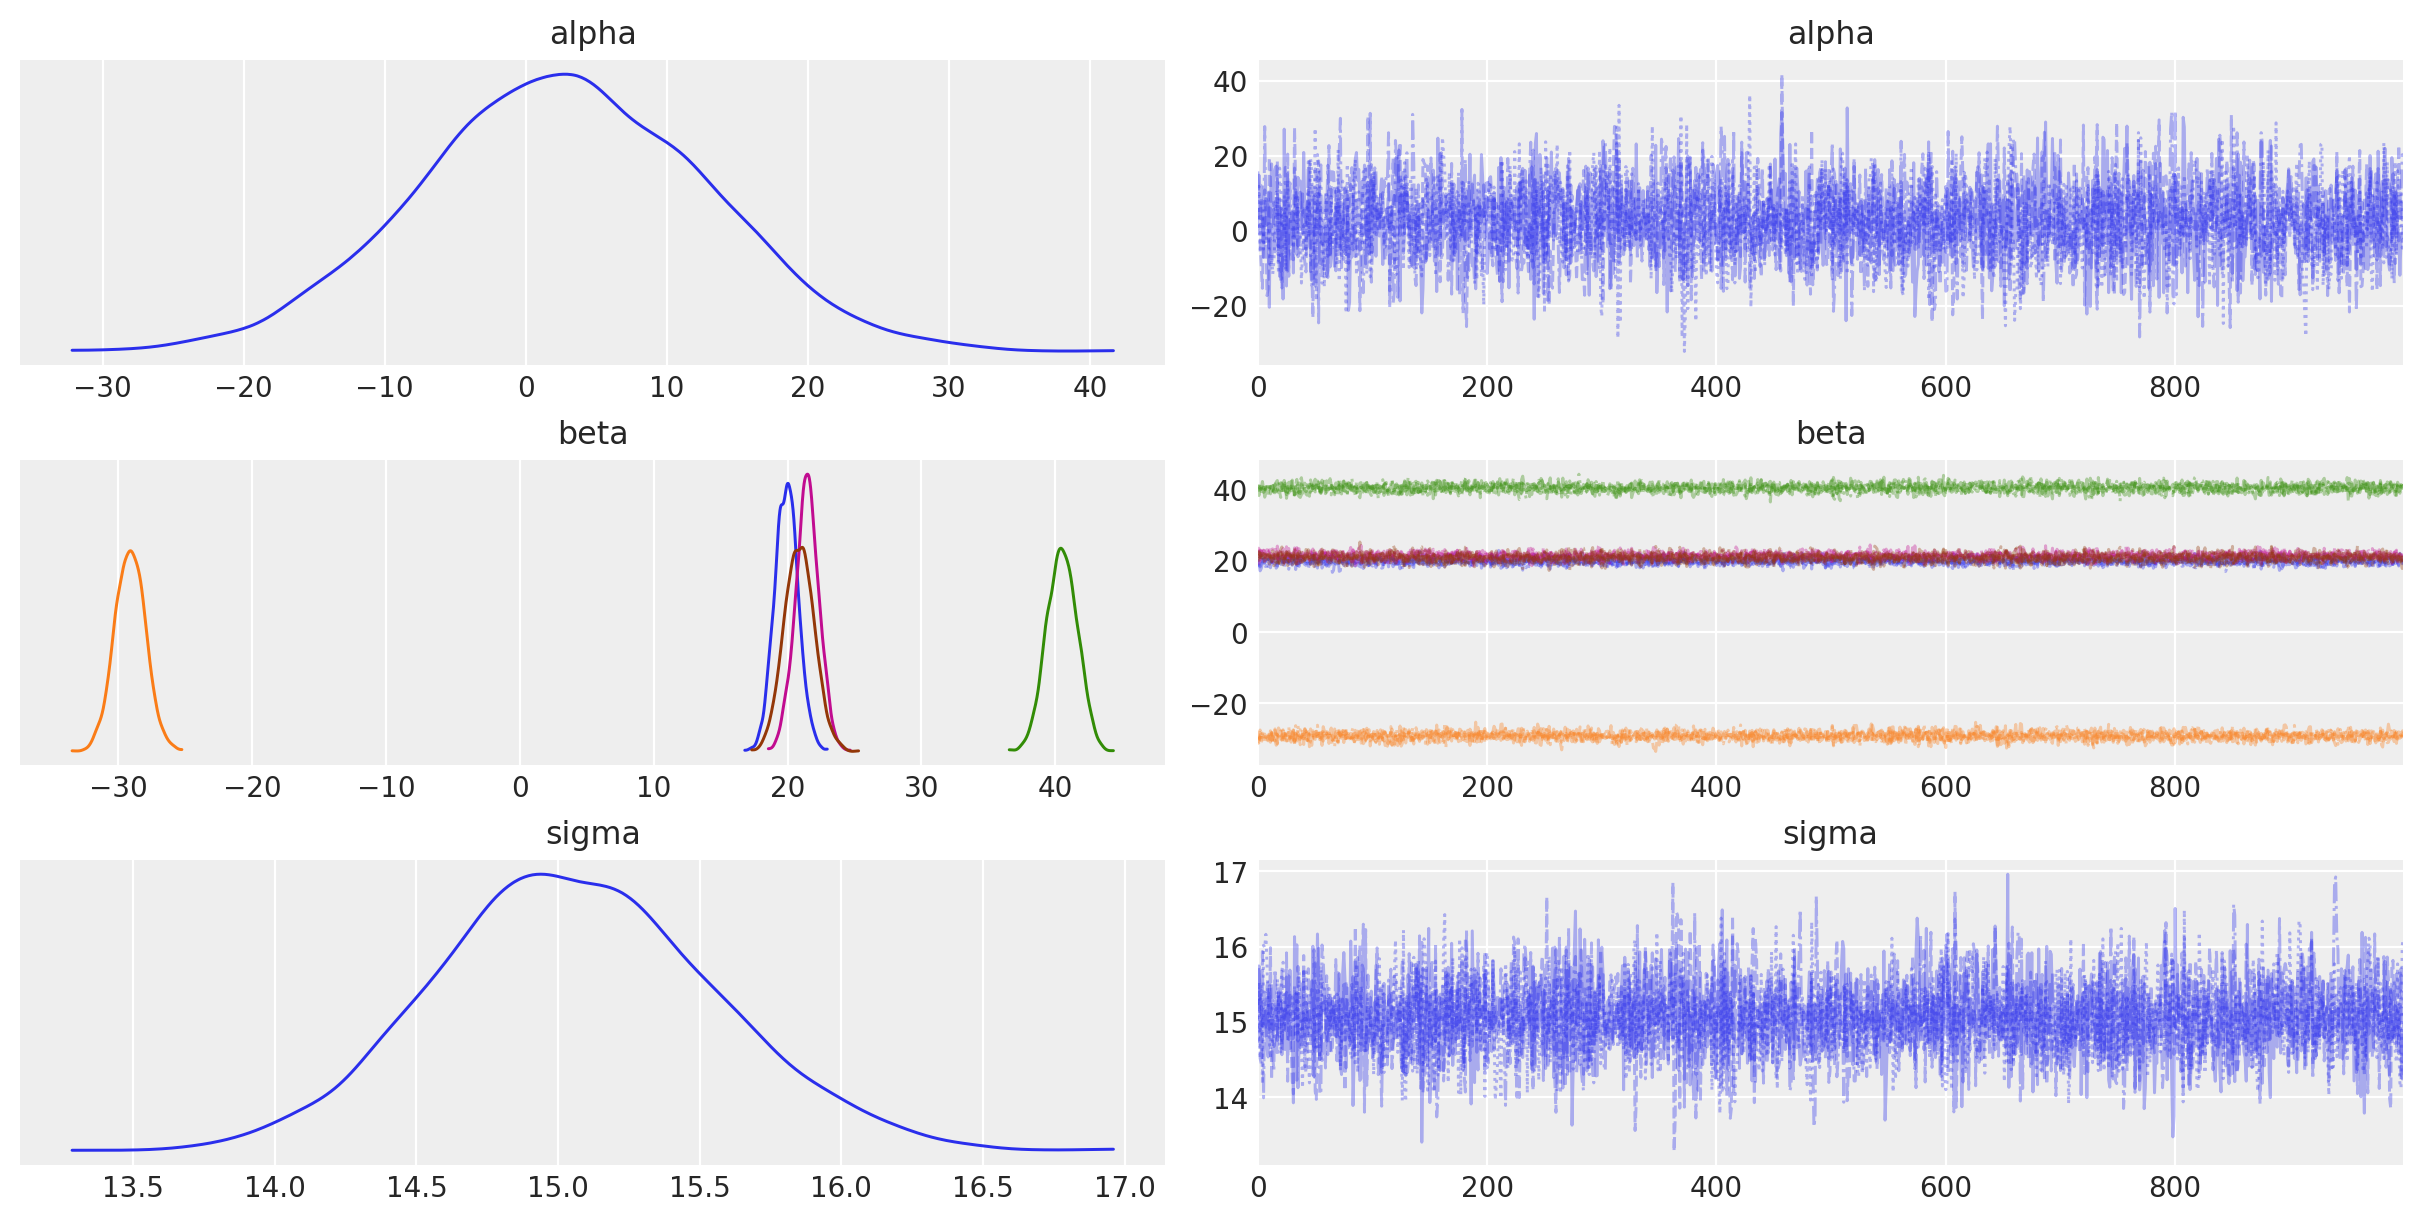

In [8]:
# Posterior Analysis
az.plot_trace(idata, combined=True);

In [ ]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.65,10.10,-16.73,20.67,0.17,0.16,3640.95,3115.95,1.0
beta[0],19.92,0.87,18.27,21.56,0.01,0.01,4152.96,2893.94,1.0
beta[1],-29.13,1.15,-31.23,-26.90,0.02,0.02,3454.29,2803.07,1.0
beta[2],40.50,1.13,38.39,42.61,0.02,0.02,3477.44,2835.21,1.0
beta[3],21.47,0.89,19.79,23.18,0.01,0.02,4065.24,2881.64,1.0
beta[4],20.87,1.11,18.72,22.88,0.02,0.02,3509.83,2791.88,1.0
sigma,15.06,0.50,14.12,16.00,0.01,0.01,5143.59,2894.37,1.0


## Summary

For the given model, we obtain the posterior distributions of the coefficients and the noise term. The posterior distributions will give us the estimates of the coefficients and the uncertainty associated with them. The final model is:

### $ Y (Loss) = 2.65 + 19.92 * T_1 -29.13 * T_2 + 40.5 * T_3 + 21.47 * T_4 + 20.87 * T_5 + \epsilon$

where $\epsilon$ is the noise term.